In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats
from scipy.stats import norm, skew #for some statistics
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading the datasets using Pandas built in read_csv function

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Introduction to the training dataset

From the author, he mentioned that there are 23 nominal (Not ordered) and 23 ordinal (in specific orders, i.e. Overall Condition) categorical variables, 20 continuous variables and 14 discrete variables. The **nominal** variables typically identify various types of dwellings, garages, materials, and environmental conditions while the **ordinal** variables typically rate various items within the property. 

So what are they? We can identify these variables simply by reading the documentation. Also we could have a quick look at the dataset to identify the continuous and discrete variables. Although we might notice that the OverallQual, OverallCond and MSSubClass is classified as numbers, but we do know that these 3 variables fall under the categorical variable group.

In [8]:
# Preview of the train dataset
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
# Identify the number of numeric and non-numeric columns
print(train.select_dtypes(include='object').shape[1])
print()
print(train.select_dtypes(exclude='object').shape[1])

43

38


In [10]:
# Statistics summary of the train dataset
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [11]:
# The 23 nominal categorical variables
nominal_variables = ['MSSubClass', 'MSZoning', 'Street', 'Alley','LandContour',
                     'LotConfig', 'Neighborhood', 'Condition1','Condition2', 'BldgType',
                     'HouseStyle', 'RoofStyle', 'RoofMatl','Exterior1st', 'Exterior2nd',
                     'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'GarageType',
                     'MiscFeature', 'SaleType', 'SaleCondition']

In [12]:
# The 23 ordinal categorical variables
ordinal_variables = ['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond',
                     'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                     'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual',
                     'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
                     'PoolQC', 'Fence', 'PavedDrive']

In [13]:
# The 20 continuous variables
continuous_variables = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
                        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                        'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                        '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

In [14]:
# The 14 discrete variables
discrete_variables = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
                      'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
                      'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold']

# Checking for outliers specifically in the GrLivArea column
As per mentioned by the author himself, it is recommended to remove outliers for GrLivArea > 4000.
Lets have a quick scatter plot to visualize the outliers. We can easily notice a few outliers in the plot below and lets drop them from the training set.

In [15]:
# import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='darkgrid')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


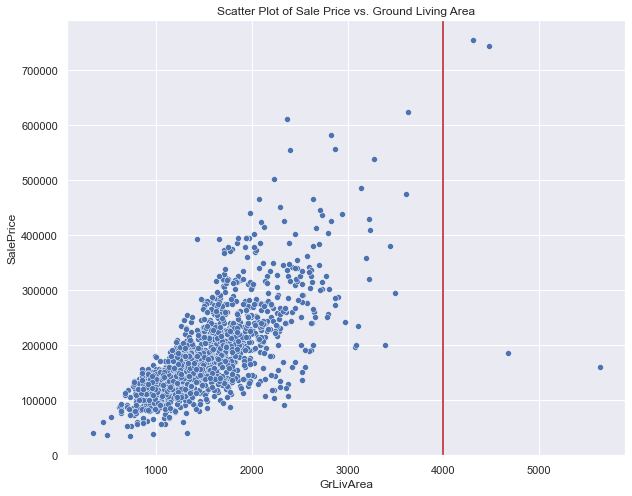

In [16]:
# Plot scatter plot of SalePrice vs. GrLivArea
plt.figure(figsize=(10,8))
sns.scatterplot(train['GrLivArea'], train['SalePrice'])
plt.axvline(x=4000, c='r', linewidth=2)
plt.title('Scatter Plot of Sale Price vs. Ground Living Area')
plt.show()

In [17]:
# We can now drop those rows
train = train.drop(train[train['GrLivArea'] > 4000].index)
print(train.shape)
print()
print(test.shape)

(1456, 81)

(1459, 80)


# Analyzing correlation between target variable and numerical features

From the heatmap below we can clearly see that the variables, OverallQual (0.8), GrLivArea (0.72) and TotalBsmtSF (0.65) show significant correlation with SalePrice.

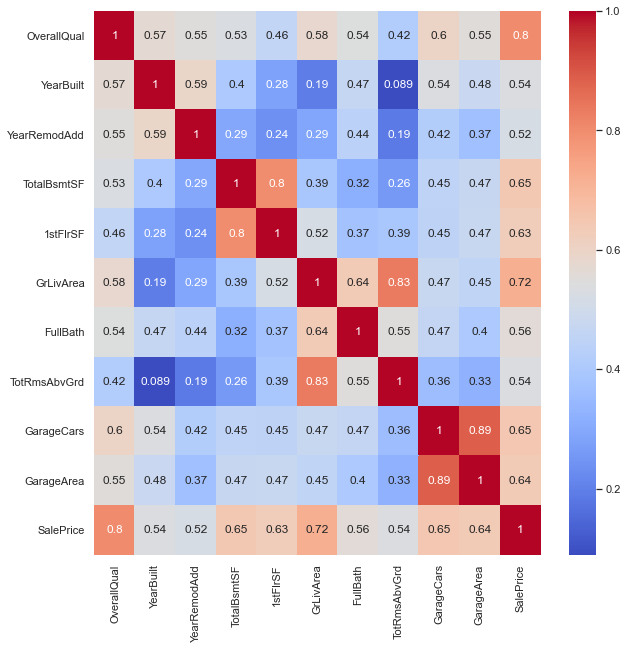

In [18]:
# highly correlated features
correlation = train.corr()
top_correlation = correlation.index[abs(correlation["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_correlation].corr(),annot=True,cmap="coolwarm")

# Analyzing and dealing with skewed data when conducting regression analyses (target variable)

Lets first analyze our target variable, which is the SalePrice and see what information that we can gather. For this we can utilize seaborn's distplot function to view the histogram and scipy's stats probplot to view the probability plot. 

*For the most part, the normal P-P plot is better at finding deviations from normality in the center of the distribution, and the normal Q-Q plot is better at finding deviations in the tails. Q-Q plots tend to be preferred in research situations. Both Q-Q and P-P plots can be used for distributions other than normal.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


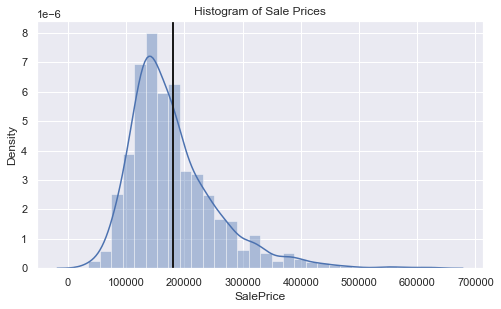

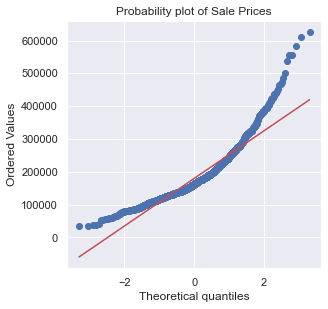

In [19]:
# Plot histogram and probability plot before log transform
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
sns.distplot(train['SalePrice'], bins=30)
plt.axvline(x=train['SalePrice'].mean(), c='k', linewidth=2)
plt.title('Histogram of Sale Prices')
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
stats.probplot(train['SalePrice'], plot=plt)
plt.title('Probability plot of Sale Prices')
plt.show()

In [20]:
# Check skewness of the target variable
train['SalePrice'].skew()

1.5659592925562151

We can see the distribution of SalePrice is heavily right skewed (showing a long right tail). And since this project focuses on machine learning with the assumption of normality in the distribution of the dataset, we simply just can't assume that the data we are working with is of normal distribution.A good approach is to transform the skewed data. Transformation technique is useful to stabilize variance, make the data more normal distribution-like, which improves the validity of measures of association. Such transformation methods are like the log-transformation, box-cox transformation, square-root transformation etc.

We can perform log transform to the target variable and plot the histogram and probabilty plot again. And from the histogram and probability plots below we can see that the sale price now is more towards being normalized at only roughly 0.065 skewness. One thing to note is that, it is very **IMPORTANT** to also transform numeric features that are skewed.

We will compare log transformation with box-cox transformation and we will choose the method that yields the better result.

In [21]:
# Create a copy and perform log transform
train_copy1 = train.copy()
train_copy1['SalePrice'] = np.log(train_copy1['SalePrice'])

In [22]:
# Import scipy special's boxcox library
from scipy.special import boxcox1p

# we will not go into detail on which lambda to select but the idea is
# the lambda will affect the transformed data's skewness
train_copy2 = train.copy()
lam = 0.15
train_copy2['SalePrice'] = boxcox1p(train_copy2['SalePrice'], lam)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


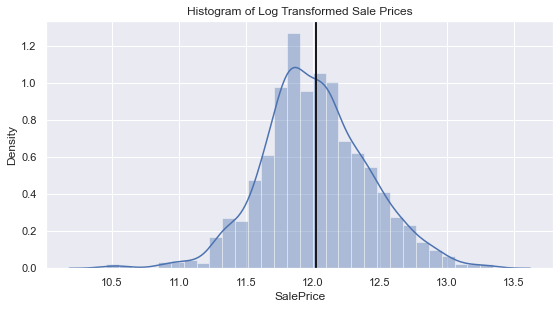

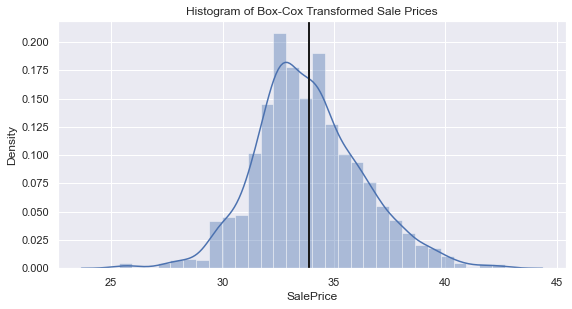

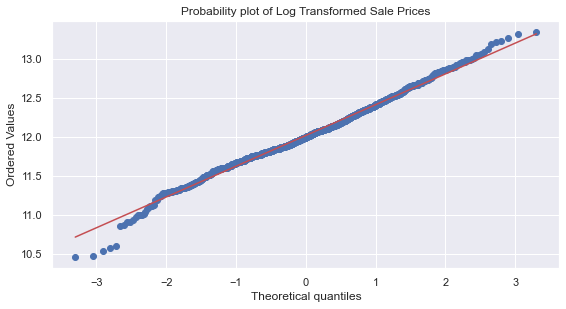

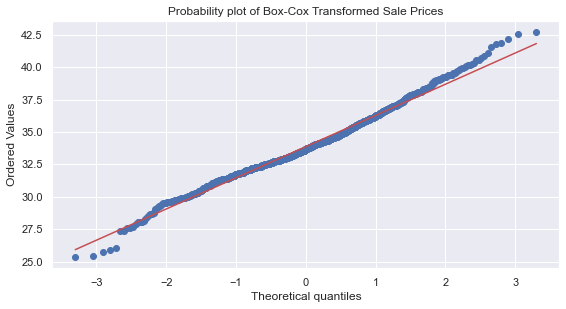

In [23]:
# Plot histogram and probability plots
plt.figure(figsize=(20, 10))
plt.subplot(2,2,1)
sns.distplot(train_copy1['SalePrice'], bins=30)
plt.axvline(train_copy1['SalePrice'].mean(), c='k', linewidth=2)
plt.title('Histogram of Log Transformed Sale Prices')

plt.figure(figsize=(20, 10))
plt.subplot(2,2,2)
sns.distplot(train_copy2['SalePrice'], bins=30)
plt.axvline(train_copy2['SalePrice'].mean(), c='k', linewidth=2)
plt.title('Histogram of Box-Cox Transformed Sale Prices')

plt.figure(figsize=(20,10))
plt.subplot(2,2,3)
stats.probplot(train_copy1['SalePrice'], plot=plt)
plt.title('Probability plot of Log Transformed Sale Prices')

plt.figure(figsize=(20,10))
plt.subplot(2,2,4)
stats.probplot(train_copy2['SalePrice'], plot=plt)
plt.title('Probability plot of Box-Cox Transformed Sale Prices')

plt.show()

In [24]:
# Skew values after transformation
log_skew = train_copy1['SalePrice'].skew()
bc_skew = train_copy2['SalePrice'].skew()

print('Log Transform: {:.3f}\nBox-Cox Transform: {:.3f}'.format(log_skew, bc_skew))

Log Transform: 0.065
Box-Cox Transform: 0.296


 It seems that we yield much better skew using log transformation. We will proceed with using this method for the dependent variable.

In [25]:
train['SalePrice'] = np.log(train['SalePrice'])

# Handling the null values in both datasets

**TRAIN SET**
- PoolQC, MiscFeature, Alley, Fence, FireplaceQu, GarageCond, GarageType, GarageFinish, GarageQual, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType2, BsmtFinType1, MasVnrType have 'NA' as an option
- LotFrontage has roughly 18% of nan values. We cannot drop this column as it holds some correlation with LotArea (0.426095) and SalePrice (0.351799). Intrinsically we can groupby the neighbourhood and compute the median value.
- In BsmtExposure, theres one row where the exposure is labelled as nan but there is a basement. So we will replace this value with 'No'.
- In BsmtFinType2, theres one row where it is labelled as nan but there is a basement. This cell will be replaced with the mode. ('Unf')
- Replace all nan values in MasVnrArea to zero.
- Replace missing Electrical row with the mode. ('SBrkr')

**TEST SET**

- LotFrontage has roughly 16% of nan values. We cannot drop this column as it holds high correlation with LotArea (0.644608). We can use the same way to fill the missing rows.
- Replace missing MSZoning rows with the mode. ('RL')
- Replace missing cells in BsmtHalfBath and BsmtFullBath in test set with zero.
- Replace missing cells in Utilities in test set with 'AllPub'.
- Replace missing cells in Functional in test set with 'Typ'. (Assume typical unless deductions are warranted)
- Replace missing cells in BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF with 0 as there is no basement recorded in (ID = 2121).
- For ID = 2218 & 2219, replace BsmtQual missing cells with the mode groupby BsmtCond. ('TA')
- For ID = 2041, 2186 & 2525, replace BsmtCond missing cells with the mode groupby BsmtQual. ('TA')
- For ID = 1488 & 2349, replace BsmtExposure missing cells with 'No'.
- Replace missing cells in Exterior1st and Exterior 2nd with the mode. ('VinylSd')
- Replace missing cell in SaleType with the mode. ('WD')
- Replace missing cell in KitchenQual with the mode. ('TA')
- GarageType has 76 null valued cells while GarageCond has 78 null valued cells. Locate the IDs for the 2 cells
    - ID 2577
    - ID 2127
- For ID = 2127, the GarageYrblt will be replaced with the year of the house was built, GarageFinish will be filled with the mode groupby GarageType, GarageQual and GarageCond will be replaced with the mode grouped by GarageYrBlt and GarageType.
- For ID = 2577, the GarageYrblt will be replaced with the year of the house was built, GarageFinish will be filled with the mode groupby GarageType, GarageQual and GarageCond will be replaced with the mode grouped by GarageYrBlt and GarageType. Replace missing cells in GarageArea and GarageCars with the median values based on the GarageYrblt, GarageFinish, GarageQual and GarageCond. 
- Replace missing MasVnrType cell in ID = 2611 with the mode groupby on MasVnrArea.

In [26]:
# look at the null values in train set
train.isnull().sum().sort_values(ascending=False)[:19]

PoolQC          1451
MiscFeature     1402
Alley           1365
Fence           1176
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [27]:
# look at null values in test set
test.isnull().sum().sort_values(ascending=False)[:33]

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageQual        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
BsmtUnfSF          1
TotalBsmtSF        1
SaleType           1
Exterior1st        1
KitchenQual        1
GarageArea         1
GarageCars         1
dtype: int64

# Null in train data

In [28]:
y = train[(train['BsmtExposure'].isnull()) & (train['BsmtQual'].notnull())].index
train.loc[y, 'BsmtExposure'] = train.loc[y, 'BsmtExposure'].fillna('No')

x = train[(train['BsmtFinType2'].isnull()) & (train['BsmtQual'].notnull())].index
train.loc[x, 'BsmtFinType2'] = train.loc[x, 'BsmtFinType2'].fillna('Unf')

In [29]:
# label the columns with 'NA' as a category. With an exception for 'GarageYrBlt' as those with no GarageQual
# means there isnt a garage to begin with which will be filled with zeros.
col_to_fill_NA = ['PoolQC', 'MiscFeature', 'Alley', 'Fence',
                  'FireplaceQu', 'GarageCond', 'GarageType', 'GarageFinish',
                  'GarageQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                  'BsmtFinType2', 'BsmtFinType1', 'MasVnrType']

train[col_to_fill_NA] = train[col_to_fill_NA].fillna('NA')

In [30]:
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)
train['MasVnrArea'] = train['MasVnrArea'].fillna(0)
train['Electrical'] = train['Electrical'].fillna('SBrkr')

In [31]:
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

# Null in test data

In [32]:
id1 = test[test['Id'] == 2127].index
id2 = test[test['Id'] == 2577].index

In [33]:
test.loc[id1,'GarageYrBlt'] = test.loc[id1, 'GarageYrBlt'].fillna(test.loc[id1,'YearBuilt'].values[0])
test.loc[id1,'GarageFinish'] = (test
                                .groupby('GarageType')['GarageFinish']
                                .apply(lambda x: x.fillna(x.mode().values[0]))
                               )
test.loc[id1,'GarageQual'] = (test
                              .groupby(['GarageYrBlt', 'GarageType'])['GarageQual']
                              .apply(lambda x: x.fillna(x.mode().values[0]))
                             )
test.loc[id1,'GarageCond'] = (test
                              .groupby(['GarageYrBlt', 'GarageType'])['GarageCond']
                              .apply(lambda x: x.fillna(x.mode().values[0]))
                             )

In [34]:
test.loc[id2,'GarageYrBlt'] = test.loc[id2, 'GarageYrBlt'].fillna(test.loc[id1,'YearBuilt'].values[0])
test.loc[id2,'GarageFinish'] = (test
                                .groupby('GarageType')['GarageFinish']
                                .apply(lambda x: x.fillna(x.mode().values[0]))
                               )
test.loc[id2,'GarageQual'] = (test
                              .groupby(['GarageYrBlt', 'GarageType'])['GarageQual']
                              .apply(lambda x: x.fillna(x.mode().values[0]))
                             )
test.loc[id2,'GarageCond'] = (test
                              .groupby(['GarageYrBlt', 'GarageType'])['GarageCond']
                              .apply(lambda x: x.fillna(x.mode().values[0]))
                             )
test.loc[id2, 'GarageCars'] = (test
                               .groupby(['GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond'])['GarageCars']
                               .apply(lambda x: x.fillna(x.median()))
                              )
test.loc[id2, 'GarageArea'] = (test
                               .groupby(['GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond'])['GarageArea']
                               .apply(lambda x: x.fillna(x.median()))
                              )

In [35]:
id3 = test[test['MasVnrArea'].notnull() & test['MasVnrType'].isnull()].index
test.loc[id3, 'MasVnrType'] = test.groupby('MasVnrArea')['MasVnrType'].apply(lambda x: x.fillna(x.mode().values[0]))

In [36]:
test.loc[:,['BsmtHalfBath', 'BsmtFullBath']] = test.loc[:,['BsmtHalfBath', 'BsmtFullBath']].fillna(0)
test[['Exterior1st', 'Exterior2nd']] = test[['Exterior1st', 'Exterior2nd']].fillna('VinylSd')
test['MSZoning'] = test['MSZoning'].fillna('RL')
test['Utilities'] = test['Utilities'].fillna('AllPub')
test['Functional'] = test['Functional'].fillna('Typ')
test['SaleType'] = test['SaleType'].fillna('WD')
test['KitchenQual'] = test['KitchenQual'].fillna('TA')
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)

In [37]:
id4 = test[test['Id'] == 2121].index
test.loc[id4, ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']] = test.loc[id4, ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']].fillna(0)

In [38]:
# locate the ids with either BsmtQual is missing but with BsmtCond values and vice versa
id5 = test[(
            test['BsmtCond'].isnull() & test['BsmtQual'].notnull()
            ) |  (
                  test['BsmtCond'].notnull() & test['BsmtQual'].isnull()
                  )
          ].index

test.loc[id5, 'BsmtQual'] = test.loc[id5, 'BsmtQual'].fillna('TA')
test.loc[id5, 'BsmtCond'] = test.loc[id5, 'BsmtQual'].fillna('TA')

In [39]:
id6 = test[(test['BsmtExposure'].isnull()) & (test['BsmtQual'].notnull())].index
test.loc[id6, 'BsmtExposure'] = test.loc[id6, 'BsmtExposure'].fillna('No')

In [40]:
test[col_to_fill_NA] = test[col_to_fill_NA].fillna('NA')

In [41]:
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0)

In [42]:
test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [43]:
# Double checking the datasets
print(train.isnull().sum())
print()
print(test.isnull().sum())

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr

# So now we have sorted all the null values, we can then proceed to create new features
Knowing that the prices for houses are mostly affected by the location, condition, size and type of the house, the facilities it provides, the year it was built and the year it was sold. Based on these intrinsic features that we can think off from a very basic point of view, we can now create and simplify the features that we need.

To make things easier, we are going to combine both train and test datasets for this part of the analysis and then separate them again before fitting it to our machine learning models. We can actually perform this step before starting the data cleaning as well. I personally prefer to work the datasets separately when handling null values.

We should also convert the categorical variables - ['MSSubClass', 'OverallQual', 'OverallCond'] from integers to string type. The year and month sold variables are converted into string type as well.

In [44]:
# Combine both data sets and drop the 'Id' column
df = train.append(test)
df = df.drop('Id', axis=1)

In [45]:
# Convert these variables to str type
df[['MSSubClass', 'OverallQual', 'OverallCond']] = df[['MSSubClass', 'OverallQual', 'OverallCond']].astype(str)
df[['MoSold', 'YrSold']] = df[['MoSold', 'YrSold']].astype(str)

In [46]:
# Creating new features and lowering the cardinality of the dataset
df['TotalHouseSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
df['TotalBathrooms'] = df['BsmtFullBath'] + df['BsmtHalfBath'] + df['FullBath'] + df['HalfBath']
df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['HasBasement'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
df['HasWoodDeck'] = df['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)

In [47]:
# Drop the unwanted columns
drop_col = ['1stFlrSF', '2ndFlrSF', 'BsmtFullBath',
            'BsmtHalfBath', 'FullBath', 'HalfBath', 'OpenPorchSF',
            'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
df = df.drop(drop_col, axis=1)

# Lets move on to checking skewness found in the feature variables



In [48]:
# Create a new dataframe consist of only numeric variables
num_df = df.select_dtypes(exclude = 'object')

# Check skew of all numerical features
num_skew = num_df.apply(lambda x: x.skew()).sort_values(ascending=False)
skew_df = pd.DataFrame({'Skew': num_skew})
skew_df

,Skew
MiscVal,21.943440
PoolArea,18.711459
HasPool,16.194866
LotArea,13.130516
LowQualFinSF,12.086535
KitchenAbvGr,4.301059
BsmtFinSF2,4.144996
MasVnrArea,2.602036
TotalPorchSF,2.244587
WoodDeckSF,1.849236


# We can then perform box-cox transformation on the independent variables as well.

Only select the features with relatively high skew (>0.5) and exclude the new features that we created.

In [49]:
high_skew_df = skew_df[(skew_df['Skew']>0.5) | (skew_df['Skew']<-0.5)]

# Exclude new features and year columns
exclude_features = ['HasPool', 'HasGarage', 'HasBasement', 'HasFireplace', 'HasWoodDeck', 'YearBuilt', 'GarageYrBlt']
high_skew_df = high_skew_df[high_skew_df.index.isin(exclude_features) == False]
high_skew_features = high_skew_df.index

# Perform box-cox transformation with specified lambda
lam = 0.15
for feat in high_skew_features:
    df[feat] = boxcox1p(df[feat], lam)

# Perform label encoding to all ordinal variables

In [50]:
# perform label encoding
from sklearn.preprocessing import LabelEncoder
    
for col in ordinal_variables:
    df[col] = LabelEncoder().fit_transform(df[col])

In [51]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalHouseSF,TotalPorchSF,TotalBathrooms,HasPool,HasGarage,HasBasement,HasFireplace,HasWoodDeck
0,60,RL,5.831328,19.212182,Pave,NA,3,Lvl,0,Inside,0,CollgCr,Norm,Norm,1Fam,2Story,7,4,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,8.059126,2,4,PConc,2,4,4,2,11.170327,6,0.0,7.483296,11.692623,GasA,0,Y,4,0.0,13.698888,3,0.730463,2,2.602594,6,0.000000,3,Attchd,2003.0,2,2.0,548.0,5,5,2,0.000000,0.0,3,4,NA,0.0,2,2008,WD,Normal,12.247694,14.976591,5.714669,4.0,0,1,1,0,0
1,20,RL,6.221214,19.712205,Pave,NA,3,Lvl,0,FR2,0,Veenker,Feedr,Norm,1Fam,1Story,6,7,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,3,4,CBlock,2,4,1,0,12.062832,6,0.0,8.897844,12.792276,GasA,0,Y,4,0.0,12.792276,3,0.730463,3,2.259674,6,0.730463,5,Attchd,1976.0,2,2.0,460.0,5,5,2,9.010206,0.0,3,4,NA,0.0,5,2007,WD,Normal,12.109011,14.923100,0.000000,3.0,0,1,1,1,1
2,60,RL,5.914940,20.347241,Pave,NA,0,Lvl,0,Inside,0,CollgCr,Norm,Norm,1Fam,2Story,7,4,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,7.646538,2,4,PConc,2,4,2,2,10.200343,6,0.0,9.917060,11.892039,GasA,0,Y,4,0.0,13.832085,3,0.730463,2,2.259674,6,0.730463,5,Attchd,2001.0,2,2.0,608.0,5,5,2,0.000000,0.0,3,4,NA,0.0,9,2008,WD,Normal,12.317167,15.149678,5.053371,4.0,0,1,1,1,0
3,70,RL,5.684507,19.691553,Pave,NA,0,Lvl,0,Corner,0,Crawfor,Norm,Norm,1Fam,2Story,7,4,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,3,4,BrkTil,4,1,4,0,8.274266,6,0.0,10.468500,11.354094,GasA,2,Y,4,0.0,13.711364,3,0.730463,2,2.440268,6,0.730463,2,Detchd,1998.0,3,3.0,642.0,5,5,2,0.000000,0.0,3,4,NA,0.0,2,2006,WD,Abnorml,11.849398,14.857121,9.080098,2.0,0,1,1,1,0
4,60,RL,6.314735,21.325160,Pave,NA,0,Lvl,0,FR2,0,NoRidge,Norm,Norm,1Fam,2Story,8,4,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,9.391827,2,4,PConc,2,4,0,2,10.971129,6,0.0,10.221051,12.510588,GasA,0,Y,4,0.0,14.480029,4,0.730463,2,2.750250,6,0.730463,5,Attchd,2000.0,2,3.0,836.0,5,5,2,8.013884,0.0,3,4,NA,0.0,12,2008,WD,Normal,12.429216,15.852312,6.314735,4.0,0,1,1,1,1


# Perform One Hot Encoding to all nominal variables

In [52]:
# Perform one hot encoding
from sklearn.preprocessing import OneHotEncoder

nominal_variables = ['MSSubClass', 'MSZoning', 'Street', 'Alley','LandContour',
                     'LotConfig', 'Neighborhood', 'Condition1','Condition2', 'BldgType',
                     'HouseStyle', 'RoofStyle', 'RoofMatl','Exterior1st', 'Exterior2nd',
                     'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'GarageType',
                     'MiscFeature', 'SaleType', 'SaleCondition', 'MoSold', 'YrSold']

encoded_features = []
for col in nominal_variables:
    encoded_feat = OneHotEncoder().fit_transform(df[col].values.reshape(-1, 1)).toarray()
    n = df[col].nunique()
    cols = ['{}_{}'.format(col, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = df.index
    encoded_features.append(encoded_df)

df = pd.concat([df, *encoded_features], axis=1).drop(nominal_variables, axis=1)



In [53]:
df.head()

,LotFrontage,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,Electrical,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,PoolArea,PoolQC,Fence,MiscVal,SalePrice,TotalHouseSF,TotalPorchSF,TotalBathrooms,HasPool,HasGarage,HasBasement,HasFireplace,HasWoodDeck,MSSubClass_1,MSSubClass_2,MSSubClass_3,MSSubClass_4,MSSubClass_5,MSSubClass_6,MSSubClass_7,MSSubClass_8,MSSubClass_9,MSSubClass_10,MSSubClass_11,MSSubClass_12,MSSubClass_13,MSSubClass_14,MSSubClass_15,MSSubClass_16,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,MSZoning_5,Street_1,Street_2,Alley_1,Alley_2,Alley_3,LandContour_1,LandContour_2,LandContour_3,LandContour_4,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LotConfig_5,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Neighborhood_25,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition1_9,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,Condition2_7,Condition2_8,BldgType_1,BldgType_2,BldgType_3,BldgType_4,BldgType_5,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,HouseStyle_8,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofStyle_6,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,RoofMatl_7,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior1st_15,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,Exterior2nd_16,MasVnrType_1,MasVnrType_2,MasVnrType_3,MasVnrType_4,MasVnrType_5,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,Foundation_6,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,Heating_6,CentralAir_1,CentralAir_2,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,GarageType_6,GarageType_7,MiscFeature_1,MiscFeature_2,MiscFeature_3,MiscFeature_4,MiscFeature_5,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleType_9,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,SaleCondition_6,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_1,YrSold_2,YrSold_3,YrSold_4,YrSold_5
0,5.831328,19.212182,3,0,0,7,4,2003,2003,8.059126,2,4,2,4,4,2,11.170327,6,0.0,7.483296,11.692623,0,4,0.0,13.698888,3,0.730463,2,2.602594,6,0.000000,3,2003.0,2,2.0,548.0,5,5,2,0.000000,0.0,3,4,0.0,12.247694,14.976591,5.714669,4.0,0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,

# So now we have our dataset ready, we will fit several regression models and predict the housing sale prices.

The models used are:
* LinearRegression
* Lasso
* Ridge
* RandomForestRegressor
* GradientBoostingRegressor

The models are kept at their default state as i will not go into details for parameter tuning. This can be done using GridSearchCV. I will probably further tune it in the near future.

In [54]:
# Now we can split the data into train and test sets again
df_train = df[:1456]
df_test = df[1456:]

In [55]:
# Compute training and test variables
X_train = df_train.drop('SalePrice', axis=1)
y_train = df_train['SalePrice']
X_test = df_test.drop('SalePrice', axis=1)

In [56]:
# Just to confirm that both datasets has the same amount of columns
print(X_train.shape)
print(X_test.shape)

(1456, 249)
(1459, 249)


In [57]:
# import necessary libraries
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split

In [58]:
# Create variables for all import regression models
lin = LinearRegression()
ridge = Ridge()
lasso = Lasso()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()

In [59]:
# Define a function to calculate rsme for different models

kfold = KFold(n_splits=10)
def rmsle_cv(model):
    kfold = KFold(n_splits=10)
    rmse= np.sqrt(abs(cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kfold)))
    return(rmse)

In [60]:
# Linear Regression
score = rmsle_cv(lin)
print('Linear Regression score: {:.3f}'.format(score.mean()))

Linear Regression score: 20173751.631


In [61]:
# Ridge Regression
score = rmsle_cv(ridge)
print('Ridge Regression score: {:.3f}'.format(score.mean()))

Ridge Regression score: 0.116


In [62]:
# Lasso Regression
score = rmsle_cv(lasso)
print('Lasso Regression score: {:.3f}'.format(score.mean()))

Lasso Regression score: 0.263


In [63]:
# Gradient Boosting
score = rmsle_cv(gb)
print('Gradient Boosting score: {:.3f}'.format(score.mean()))

Gradient Boosting score: 0.120


In [64]:
# Random Forest
score = rmsle_cv(rf)
print('Random Forest score: {:.3f}'.format(score.mean()))

Random Forest score: 0.132


So it seems like ridge regression is performing the best with the lowest RMSE. We will proceed with fitting the model and predict the housing sale prices.

In [65]:
# Fitting the ridge model
ridge_model = ridge.fit(X_train, y_train)

# Predicting prices
X_pred = ridge_model.predict(X_test)

Now we have to re-transform the predicted sale prices back to their inital state

In [66]:
X_pred = np.expm1(X_pred)

In [67]:
# Compute submission dataframe

output = pd.DataFrame()
output['Id'] = test['Id']
output['SalePrice'] = X_pred
output.to_csv('submission.csv',index=False)